In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


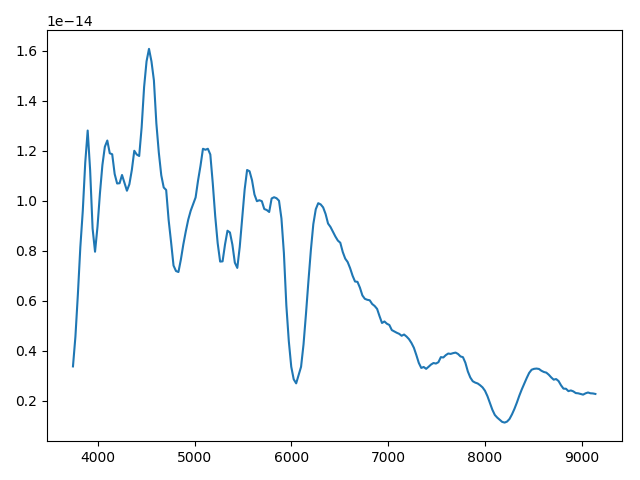

In [179]:
# read spec data
z = 0.00888
spec = '/Users/adamamiller/astronomy/ZTF/SN19yvq/data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'

spec_df = pd.read_csv(spec, comment='#', delim_whitespace=True, header=None)
wv = spec_df[0].values
fl = spec_df[1].values

plt.figure()
plt.plot(wv/(1+z), fl)
plt.tight_layout()

In [154]:
def lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    
    mean_vel, lnvar, amplitude = theta
    var_vel = np.exp(lnvar)
    
    model_flux = np.ones_like(vel_rf)
    model_flux += amplitude*1/np.sqrt(2*np.pi*var_vel)*np.exp(-1/(2*var_vel)*(vel_rf - mean_vel)**2)
    if len(delta_vel_components) > 0:
        for delta_vel in delta_vel_components:
            model_flux += amplitude*1/np.sqrt(2*np.pi*var_vel)*np.exp(-1/(2*var_vel)*((vel_rf-delta_vel) - mean_vel)**2)
    
    lnl = - 0.5*len(model_flux)*np.log(2*np.pi) - np.sum(np.log(flux_unc)) -0.5*np.sum((norm_flux - model_flux)**2 / flux_unc**2) 
    
    return lnl

def neg_lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    lnl = lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                              delta_vel_components=delta_vel_components, 
                              flux_unc = flux_unc)
    return -1*lnl

In [91]:
def divide_continuum(lambda_rf, flux, blue_continuum, red_continuum):
    '''Divide out linear continuum factor'''
    
    linear_continuum = lambda slope, wave, wave0, flux0: slope*(wave - wave0) + flux0
    
    slope = (blue_continuum[1]-red_continuum[1])/(blue_continuum[0] - red_continuum[0])
    norm_flux = flux/linear_continuum(slope, lambda_rf, blue_continuum[0], blue_continuum[1])
    
    return norm_flux

In [168]:
norm_flux = divide_continuum(wv/(1+z), fl, (5830, 1.01e-14), (6288,9.84e-15))

In [180]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c*((lambda_rf/lambda_0)**2 - 1)/((lambda_rf/lambda_0)**2 + 1)
    
    return v

In [181]:
delta_vel = velocity_rf(6371.37, 6347.11)
delta_vel

1143.6804664041479

In [182]:
theta = (-15893.41748703,     16.70304233,  -4133.73835717)
# theta = (-14000, np.log(16e6), -8e3)

line_region = np.where((wv/(1+z) > 5853) & 
                       (wv/(1+z) < 6373))
lnlike_gaussian_abs(theta, vel_rf[line_region], 
                        norm_flux[line_region], 
                        delta_vel_components=[delta_vel])

-18.394428532497827

<IPython.core.display.Javascript object>


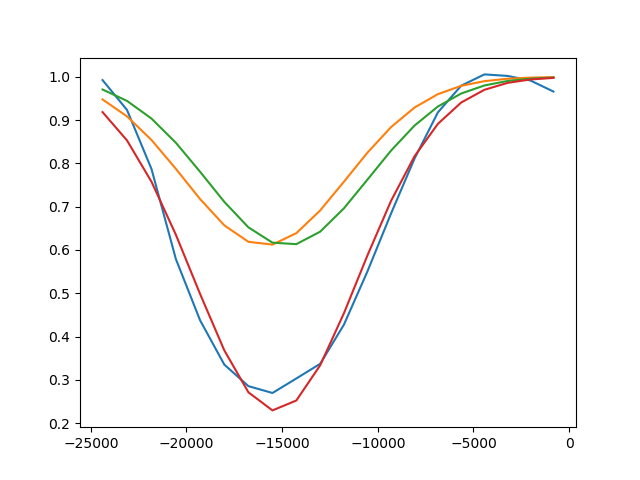

In [183]:
mean, lnvar, amp = theta
var = np.exp(lnvar)

plt.figure()
plt.plot(vel_rf[line_region], norm_flux[line_region])
plt.plot(vel_rf[line_region], 1 + calc_gauss(vel_rf[line_region], 
                                              mean, var, amp))
plt.plot(vel_rf[line_region], 1 + calc_gauss(vel_rf[line_region], 
                                              mean+delta_vel, var, amp))
plt.plot(vel_rf[line_region], 1 + calc_gauss(vel_rf[line_region], 
                                              mean+delta_vel, var, amp) + calc_gauss(vel_rf[line_region], 
                                              mean, var, amp))

In [58]:
def calc_gauss(x, mean, var, amp):
    return amp/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x-mean)**2/var)

In [175]:
from scipy.optimize import minimize

ml_res = minimize(neg_lnlike_gaussian_abs, (-14000, np.log(16e6), -8e3), method='Powell', # Powell method does not need derivatives
                      args=(vel_rf[line_region], norm_flux[line_region], [delta_vel]))

In [176]:
ml_res

   direc: array([[ 7.58560091e+02, -3.16758416e-01,  5.24367848e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.25814393e+02, -6.98092225e-02,  2.48974710e+01]])
     fun: 18.39442853249675
 message: 'Optimization terminated successfully.'
    nfev: 226
     nit: 6
  status: 0
 success: True
       x: array([-15893.41748703,     16.70304233,  -4133.73835717])

In [185]:
beta = 2*ml_res.x[2]/2.99792458e5

(1 - np.sqrt((1+beta)/(1-beta)))*6371

173.33805610930207

## Build in OOP

In [218]:
class SpectrumSN():
    '''1D optical spectrum'''
    
    def __init__(self, wave, flux, z=0, flux_unc=0):
        self.wave = wave
        self.flux = flux
        self.lambda_rf = wave/(1+z)
        self.res_dict = {}
    
    def measure_vel_and_ew(self, blue_edge, red_edge,
                           fit_region = [],
                           guess = (-10000, 10, -1000),
                           lambda_0 = 6562.85,
                           line_name = 'Halpha',
                           delta_vel = []):
        '''Measure the velocity and equivalent width'''
        
        if len(fit_region) == 0:
            fit_region = [blue_edge[0], red_edge[0]]
            
        norm_flux = divide_continuum(self.lambda_rf, self.flux, 
                                     blue_edge, red_edge)
        v_rf = velocity_rf(self.lambda_rf, lambda_0)
        line = np.where((self.lambda_rf >= fit_region[0]) & 
                        (self.lambda_rf <= fit_region[1]))
        
        vel_fit = minimize(neg_lnlike_gaussian_abs, guess, method='Powell',
                           args=(v_rf[line], norm_flux[line], [delta_vel]))
        v_absorb = vel_fit.x[0]
        beta = vel_fit.x[2]*(len(delta_vel)+1)/2.99792458e5
        ew = lambda_0*(1-np.sqrt((1+beta)/(1-beta)))
        
        self.res_dict[line_name] = (v_absorb, ew)
    
    def si_6355(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 10, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                           fit_region = fit_region,
                           guess = guess,
                           lambda_0 = 6371.37,
                           line_name = 'Si6355',
                           delta_vel = [1143.680466])

In [219]:
minus13 = SpectrumSN(wv, fl, z=z)

In [221]:
minus13.si_6355((5830, 1.01e-14), (6288,9.84e-15),
                guess = (-15893.41748703,     16.70304233,  -4133.73835717))

In [222]:
minus13.res_dict

{'Si6355': (-15886.310111317996, 173.0512767245486)}